
&nbsp; 
  
#  <center>The Umpire Model</center>
## <center>Can we use Major League Baseball Statcast pitching metrics to classify balls and strikes?</center>
##### <center>University of Colorado Boulder | Introduction to Machine Learning: Supervised Learning - Final Project</center>
##### <center>Jeremy Hurley | October, 2024</center>

&nbsp;  

---  

&nbsp;  
  

# Introduction:  
In Major League Baseball (MLB), determining balls and strikes is one of the most fundamental, yet important parts of the game. For those that aren't familiar with the rules of baseball, a pitch is called a strike if it crosses home plate within a designated strike zone. MLB defines the strike zone as:  
  
> the area over home plate from the midpoint between a batter's shoulders and the top of the uniform pants -- when the batter is in his stance and prepared to swing at a pitched ball -- and a point just below the kneecap.

One of the longstanding issues in baseball is that balls and strikes are subject to human error and interpretation. Pitches, some of which can reach 105 MPH, while moving both vertically and laterally, are called by human umpires who are standing behind the catcher. Generally, MLB umpires do an amazing job calling pitches, but they do miss one every now and then and, depending on the situation, the consequences can be substantial.  
  
This project aims to build a predictive model that **classifies** whether a pitch will be a ball or strike based on the x/y coordinates of where the pitch crossed the plate, the pitch type and possibly other features such as the angle of delivery. Specific models used in this project will be discussed in the Models section.  
  
The data for this project was generated by Statcast, which is an advanced tracking system introduced by the MLB in 2015. Statcast uses radar and optical cameras to record metric information on every play of every game in the MLB, including ball velocity, spin rates, launch angles and player movements.  

This project serves to demonstrate the ability to use machine learning to not only show the potential for enhancements in how a baseball game is officiated, but, when applied properly, to also give the pitcher or hitter insight into how they might use human nature to their advantage depending on the game situation. This topic will be discussed further as potential future work in the Discussion and Conclusions section.  
  
&nbsp;  

---  

&nbsp;  
  

# Data:  
The data for this project was pulled from the pybaseball Python package.    
  
The pybaseball Python package was developed by James LeDoux. It pulls data from multiple data sources, including FanGraphs, Baseball Reference and Baseball Savant. It contains a vast amount of data from every MLB game played in the modern era. For more information on pybaseball, find it's GitHub repo [here](https://github.com/jldbc/pybaseball)  
  
Steps and descriptions of data acquisition, cleaning and saving can be found in the supplemental data notebook titled *'The Umpire Model - Data'*.  
  
This project starts by importing the dataset prepared and saved in the supplemental data notebook. Each row of the dataset represents one pitch in the 2023 MLB baseball season. Further, the dataset has been filtered to include only pitches that resulted in a ball or a called strike. Please reference the supplemental data notebook for the logic and process for creating the dataset.

In [1]:
import pandas as pd

# Load CSV file prepared in previous notebook
data = pd.read_csv('2023_strike_ball_data.csv')
data = data.dropna(subset=['release_speed'])

# Verify import
data.head()

,plate_x,plate_z,pitch_type,zone,sz_top,sz_bot,type,release_speed,release_pos_x,release_pos_z,...,strikes,pfx_x,pfx_z,plate_x.1,plate_z.1,on_3b,on_2b,on_1b,outs_when_up,pitch_name
0,-0.24,0.53,CH,13,3.71,1.78,0,90.0,-2.93,5.56,...,2,-1.65,0.36,-0.24,0.53,NaN,NaN,NaN,2,Changeup
1,0.81,0.49,ST,14,3.78,1.74,0,82.2,-3.09,5.55,...,2,1.43,0.28,0.81,0.49,NaN,NaN,NaN,2,Sweeper
2,-1.84,4.08,ST,11,3.07,1.51,0,79.4,-2.96,5.67,...,2,1.66,-0.20,-1.84,4.08,NaN,NaN,NaN,1,Sweeper
3,1.13,0.97,ST,14,3.10,1.46,0,82.9,-2.82,5.66,...,2,1.16,0.01,1.13,0.97,NaN,NaN,NaN,1,Sweeper
4,-0.65,2.34,ST,4,3.07,1.48,1,82.0,-3.00,5.69,...,1,1.45,0.06,-0.65,2.34,NaN,NaN,NaN,1,Sweeper


In [2]:
# Get column and row count information
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 358480 entries, 0 to 358480
Data columns (total 25 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   plate_x        358480 non-null  float64
 1   plate_z        358480 non-null  float64
 2   pitch_type     358480 non-null  object 
 3   zone           358480 non-null  int64  
 4   sz_top         358480 non-null  float64
 5   sz_bot         358480 non-null  float64
 6   type           358480 non-null  int64  
 7   release_speed  358480 non-null  float64
 8   release_pos_x  358480 non-null  float64
 9   release_pos_z  358480 non-null  float64
 10  release_pos_y  358480 non-null  float64
 11  description    358480 non-null  object 
 12  stand          358480 non-null  object 
 13  p_throws       358480 non-null  object 
 14  balls          358480 non-null  int64  
 15  strikes        358480 non-null  int64  
 16  pfx_x          358480 non-null  float64
 17  pfx_z          358480 non-null  fl

# Exploratory Data Analysis:
Exploratory data analysis for this project will start by examining the balance between balls and strikes and a visualization of pitch locations.

Percent of strikes: 0.33


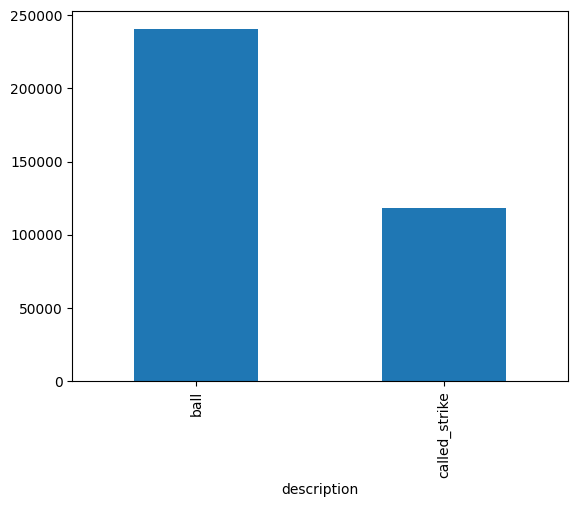

In [3]:
# Check for balance between balls and strikes.
data['description'].value_counts().plot(kind='bar')

# Mean of 'type' column will give % of strikes
print(f'Percent of strikes: {data['type'].mean():.2}')

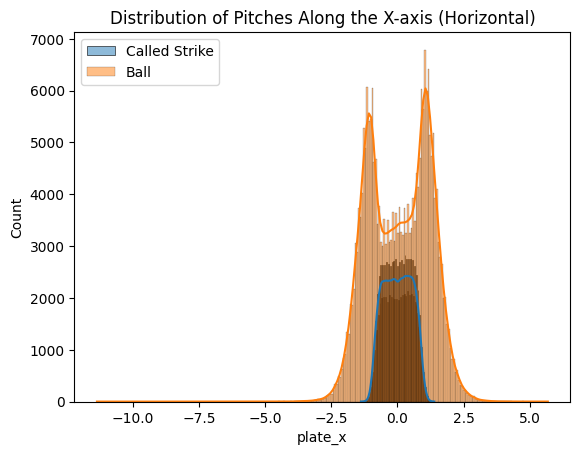

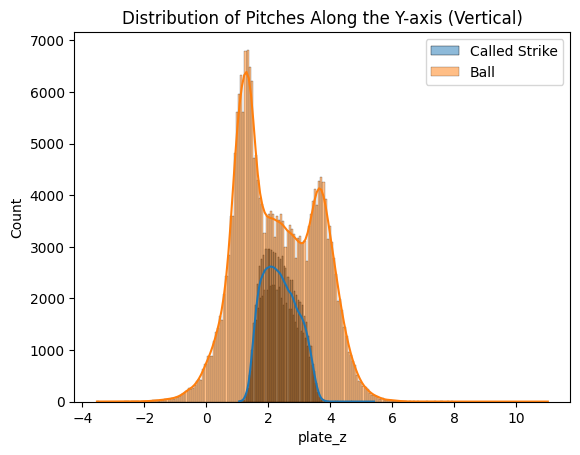

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data[data['type'] == 1]['plate_x'], label='Called Strike', kde=True)
sns.histplot(data[data['type'] == 0]['plate_x'], label='Ball', kde=True)
plt.legend()
plt.title('Distribution of Pitches Along the X-axis (Horizontal)')
plt.show()

sns.histplot(data[data['type'] == 1]['plate_z'], label='Called Strike', kde=True)
sns.histplot(data[data['type'] == 0]['plate_z'], label='Ball', kde=True)
plt.legend()
plt.title('Distribution of Pitches Along the Y-axis (Vertical)')
plt.show()

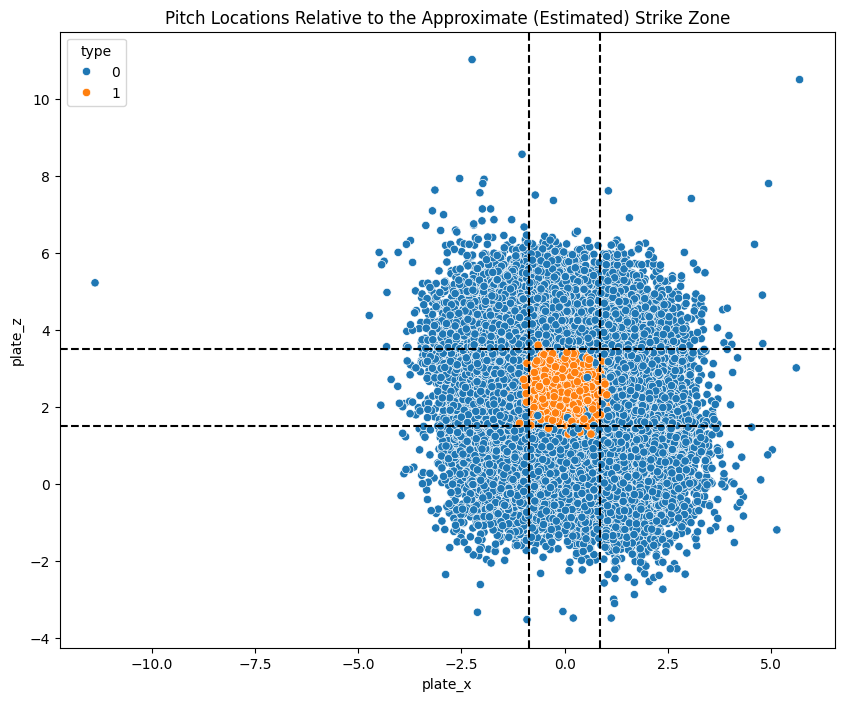

In [5]:
plt.figure(figsize=(10,8))
sns.scatterplot(x='plate_x', y='plate_z', hue='type', data=data)
plt.title('Pitch Locations Relative to the Approximate (Estimated) Strike Zone')
plt.axvline(x=0.85, color='black', linestyle='--')
plt.axvline(x=-0.85, color='black', linestyle='--')
plt.axhline(y=1.5, color='black', linestyle='--')
plt.axhline(y=3.5, color='black', linestyle='--')
plt.show()

## Exploratory Data Analysis - Preliminary Results:  
I learned two important insights about the data as a result of the EDA.  

- Balls outweigh strikes by about 2:1.
- There is a lot of noise outside what might reasonably be called a strike by an umpire.

Considering what we've learned, I will further filter the data based on vertical (plate_z) and horizontal (plate_x) position as such:  

- Remove rows where plate_z > 4.17 or < 0.83
- Remove rows where plate_x > 1.5 or < -1.5

Filtering this data removes points that would be about 8 inches or more outside the estimated strike zone. Now that Angel Hernandez is retired :), such pitches would have little chance of being called a stike and removing them will help balance the dataset and ensure the model can focus on the borerline pitches.

In [6]:
focused_data = data[
    (data['plate_x'] >= -1.5) & 
    (data['plate_x'] <= 1.5) & 
    (data['plate_z'] >= 0.83) & 
    (data['plate_z'] <= 4.17)
]

# Mean of 'type' column will give % of strikes
print(f'Percent of strikes: {focused_data['type'].mean():.2}')
print(f'Shape of new dataset: {focused_data.shape}')

Percent of strikes: 0.42
Shape of new dataset: (280401, 25)


C:\Users\hurle\OneDrive\MSDS_Colorado\DTSA 550X - CS Pathway\DTSA 5509 - Intro to Machine Learning\FinalProject\env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


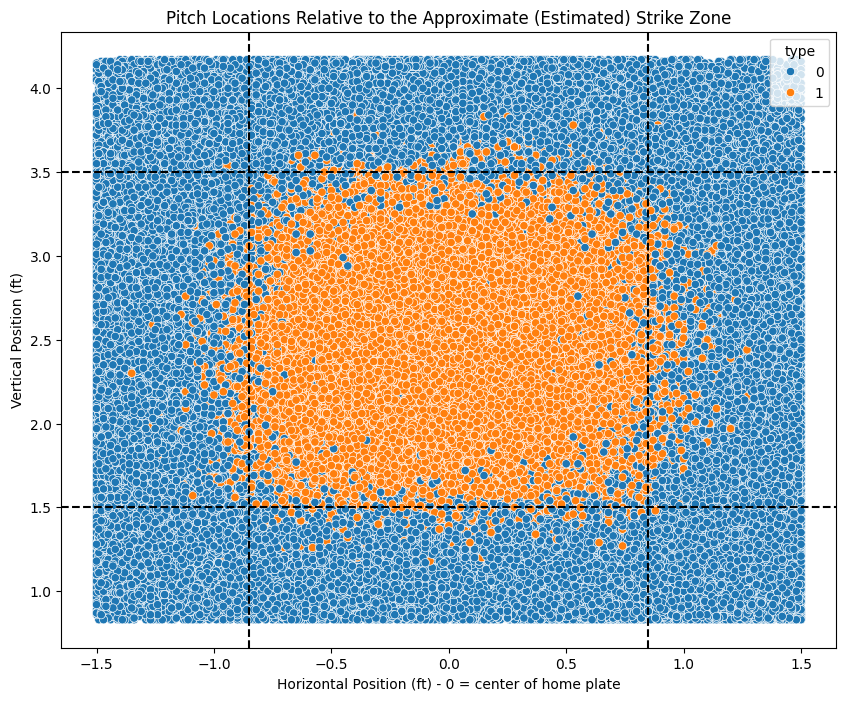

In [7]:
plt.figure(figsize=(10,8))
sns.scatterplot(x='plate_x', y='plate_z', hue='type', data=focused_data)
plt.title('Pitch Locations Relative to the Approximate (Estimated) Strike Zone')
plt.gca().set(xlabel='Horizontal Position (ft) - 0 = center of home plate', ylabel='Vertical Position (ft)')
plt.axvline(x=0.85, color='black', linestyle='--')
plt.axvline(x=-0.85, color='black', linestyle='--')
plt.axhline(y=1.5, color='black', linestyle='--')
plt.axhline(y=3.5, color='black', linestyle='--')
plt.show()

## Exploratory Data Analysis - Final Results and Conclusions:  
Exploratory data analysis was used to remove noise and add balance to the dataset.  

The dataset now contains pitch data that is either in the strike zone or within 8 inches of the expected strike zone. This should improve the model by removing noisy data and improved the balance of strike to balls from 0.33 to 0.42.

**Note:** A correlation matrix was run but not shown because there was little meaningful data or results. There was a very slight positive correlation (0.15) between release_speed and plate_z, which suggests that velocities slightly increase for pitches higher in the strike zone. This has no bearing on this project, but I found it interesting as someone who's been around baseball for most of my life, as most hitters talk about trying to lay off (not swing at) high fastballs because they look enticing, but are hard to catch up to. Maybe there is some truth to that.

# Models:
## Logistic Regression
I'm going to start by running a **Logistic Regression** model.  
I expect the logistic regression model to be less effective than K-Nearest Neighbors (KNN) or a Support Vector Machine (SVM), but will start here to get an idea of what features might be significant.  
Given that logistic regression is based on a linear model, I'm going to use **feature engineering** to change the plate_x and plate_z values into absolute distances from the center of the strike zone.  
The horizontal position (plate_x) will just take an absolute value of plate_x as the position is relative to the center of the plate. The vertical position (plate_z) will assume 2.5 is the estimated center of the strikezone (see above scatterplot) and will, therefore, take the absolute value of (plate_z - 2.5).

In [8]:
data['plate_x_norm'] = data['plate_x'].abs()
data['plate_z_norm'] = (data['plate_z'] - 2.5).abs()

The next step in modeling will be to filter out the features that I'll use and split the data into training and testing data. I'll start with a larger set of features to see what is significant. Here, I'll use the statsmodels library so I can get coefficient and p-value results to use for feature selection.  
To accomplish this, I'll use **Recursive Feature Elimination** to remove features that appear to be irrelevant. I'll start with plate_x_norm and plate_z_norm (normalized ball position features), release_speed (velocity at the point of release), pfx_x and pfx_z (movement of the pitch in the horizontal and vertical directions) and sz_top and sz_bot (estimated top and bottom of strike zone at time of pitch based on size of batter).

In [9]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# Start with filtering on features that might be relevant to the model.
X_const = data[['plate_x', 'plate_z', 'plate_x_norm', 'plate_z_norm', 'release_speed', 'pfx_x', 'pfx_z', 'sz_top', 'sz_bot']]
y = data['type']

X_const = sm.add_constant(X_const)
X_const.drop(['plate_x', 'plate_z'], axis=1, inplace=True)

logit_model = sm.Logit(y, X_const)
result = logit_model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.238302
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                   type   No. Observations:               358480
Model:                          Logit   Df Residuals:                   358472
Method:                           MLE   Df Model:                            7
Date:                Fri, 25 Oct 2024   Pseudo R-squ.:                  0.6238
Time:                        17:20:34   Log-Likelihood:                -85427.
converged:                       True   LL-Null:                   -2.2705e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             8.0825      0.164     49.221      0.000       7.761       8.404
plate_x_norm     -6.

pfx_x and pfx_z have p-values that are not significant and will be removed.

In [10]:
# remove pfx_x and pfx_z
X_const.drop(['pfx_x', 'pfx_z'], axis=1, inplace=True)

logit_model = sm.Logit(y, X_const)
result = logit_model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.238305
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                   type   No. Observations:               358480
Model:                          Logit   Df Residuals:                   358474
Method:                           MLE   Df Model:                            5
Date:                Fri, 25 Oct 2024   Pseudo R-squ.:                  0.6238
Time:                        17:20:43   Log-Likelihood:                -85427.
converged:                       True   LL-Null:                   -2.2705e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             8.0646      0.137     58.715      0.000       7.795       8.334
plate_x_norm     -6.

All features are significant according to the p-value, however, the release_speed coefficient suggests that it is adding litte to the model and will, therefore, be removed.

In [11]:
# remove release_speed
X_const.drop('release_speed', axis=1, inplace=True)

logit_model = sm.Logit(y, X_const)
result = logit_model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.238609
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                   type   No. Observations:               358480
Model:                          Logit   Df Residuals:                   358475
Method:                           MLE   Df Model:                            4
Date:                Fri, 25 Oct 2024   Pseudo R-squ.:                  0.6233
Time:                        17:21:06   Log-Likelihood:                -85537.
converged:                       True   LL-Null:                   -2.2705e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            6.7597      0.105     64.644      0.000       6.555       6.965
plate_x_norm    -6.4960

Now that all features appear to significantly contribute to the logistic regression model, I will split the data into training and testing sets and run the LogisticRegression model from sklearn on them. The split will be done using non-normalized x and z values so that I can reuse the same datasets for all models below.

In [12]:
X = data[['plate_x', 'plate_z', 'sz_top', 'sz_bot']]
y = data['type']

#split the data into training (80%) and testing (20%) sets.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test.head()

,plate_x,plate_z,sz_top,sz_bot
33837,0.98,1.69,3.23,1.68
209286,0.57,1.28,2.69,1.38
352710,1.89,2.35,3.26,1.53
338649,-0.35,2.08,3.06,1.53
140605,-1.20,2.01,3.35,1.63


In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

#make copies for use in logistic regression
lr_X_train = X_train.copy()
lr_X_test = X_test.copy()

#re-normalize the data for logistic regression
lr_X_train['plate_x_norm'] = lr_X_train['plate_x'].abs()
lr_X_train['plate_z_norm'] = (lr_X_train['plate_z'] - 2.5).abs()
lr_X_test['plate_x_norm'] = lr_X_test['plate_x'].abs()
lr_X_test['plate_z_norm'] = (lr_X_test['plate_z'] - 2.5).abs()

lr_X_train.drop(['plate_x', 'plate_z'], axis=1, inplace=True)
lr_X_test.drop(['plate_x', 'plate_z'], axis=1, inplace=True)

#initialize model
logreg = LogisticRegression()

#train model
logreg.fit(lr_X_train, y_train)

#make predictions on test set
lr_y_pred = logreg.predict(lr_X_test)

#evaluate model
print("Accuracy: ", accuracy_score(y_test, lr_y_pred))
print(classification_report(y_test, lr_y_pred))

Accuracy:  0.8906494086141487
              precision    recall  f1-score   support

           0       0.91      0.92      0.92     48265
           1       0.84      0.82      0.83     23431

    accuracy                           0.89     71696
   macro avg       0.88      0.87      0.87     71696
weighted avg       0.89      0.89      0.89     71696



## K-Nearest Neighbors (KNN)


Run an initial KNN model using n_neighbors = 5 to see how it looks.

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

# Scale the X data (keep X_train and X_test the same for use in further models)
scaler = StandardScaler()

knn_X_train = scaler.fit_transform(X_train)
knn_X_test = scaler.transform(X_test)

# define model with k=5 neighbors
knn = KNeighborsClassifier(n_neighbors=5)

# fit the model on the training data
knn.fit(knn_X_train, y_train)

# predict the test set results using the trained model
knn_y_pred = knn.predict(knn_X_test)

# Confusion Matrix
print(confusion_matrix(y_test, knn_y_pred))

#Classification Report
print(classification_report(y_test, knn_y_pred))


[[45683  2582]
 [ 2810 20621]]
              precision    recall  f1-score   support

           0       0.94      0.95      0.94     48265
           1       0.89      0.88      0.88     23431

    accuracy                           0.92     71696
   macro avg       0.92      0.91      0.91     71696
weighted avg       0.92      0.92      0.92     71696



n_neighbors = 5 looks good, but I'm going to see if that can be optimized. The following code will run models with n_neighbor values between 1 and 20 and plate the Error Rates for each.

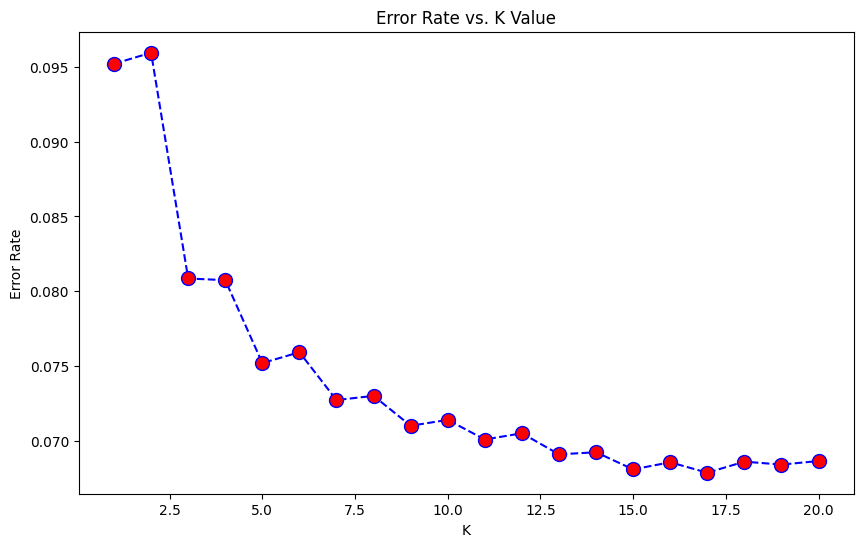

In [15]:
import numpy as np

# Test different values of K
error_rates = []
for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(knn_X_train, y_train)
    y_pred_k = knn.predict(knn_X_test)
    error_rates.append(np.mean(y_pred_k != y_test))

# Plot error rates vs K
plt.figure(figsize=(10,6))
plt.plot(range(1, 21), error_rates, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.show()

The error rate seems to drop until we reach about n_neighbors = 15, where it levels off. I'll run a final model at n_neighbors = 15 and use that for analysis.

In [17]:
# define model with k=15 neighbors
knn = KNeighborsClassifier(n_neighbors=15)

# fit the model on the training data
knn.fit(knn_X_train, y_train)

# predict the test set results using the trained model
knn15_y_pred = knn.predict(knn_X_test)

# Confusion Matrix
print(confusion_matrix(y_test, knn15_y_pred))

#Classification Report
print(classification_report(y_test, knn15_y_pred))

[[45899  2366]
 [ 2517 20914]]
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     48265
           1       0.90      0.89      0.90     23431

    accuracy                           0.93     71696
   macro avg       0.92      0.92      0.92     71696
weighted avg       0.93      0.93      0.93     71696



## Support Vector Machine (SVM)


The following code will run a Support Vector Machine with our data.

In [18]:
from sklearn.svm import SVC

# initialize SVM
svm = SVC()

# Train the model
svm.fit(X_train, y_train)

# make predictions
svm_y_pred = svm.predict(X_test)


In [20]:
print("Accuracy: ", accuracy_score(y_test, svm_y_pred))
print(classification_report(y_test, svm_y_pred))

Accuracy:  0.9305819013613033
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     48265
           1       0.90      0.89      0.89     23431

    accuracy                           0.93     71696
   macro avg       0.92      0.92      0.92     71696
weighted avg       0.93      0.93      0.93     71696



I've chosen not to optimize the SVM for several reasons. Mostly, this model was run to compare where a standard SVM would match up against the KNN model that we ran. Turns out, it matches up pretty well. Also, with the size of this dataset, this model took about 20 minutes to run. For future work, this model could be looked at further for optimization. In that case, I would look to tune the hyperparameters C and gamma. I would also run this model on the scaled dataset as I did for the KNN model.

# Results and Analysis:

I'll start by printing out the metrics so we can compare the 3 models.

In [44]:
print("Confusion Matrices")
print()
print("LR: ")
print(confusion_matrix(y_test, lr_y_pred))
print()
print("KNN: ")
print(confusion_matrix(y_test, knn15_y_pred))
print()
print("SVM: ")
print(confusion_matrix(y_test, svm_y_pred))
print()
print()
print("Classification Reports: ")
print()
print("LR: ", classification_report(y_test, lr_y_pred))
print()
print("KNN: ", classification_report(y_test, knn15_y_pred))
print()
print("SVM: ", classification_report(y_test, svm_y_pred))

Confusion Matrices

LR: 
[[44638  3627]
 [ 4213 19218]]

KNN: 
[[45899  2366]
 [ 2517 20914]]

SVM: 
[[45827  2438]
 [ 2539 20892]]


Classification Reports: 

LR:                precision    recall  f1-score   support

           0       0.91      0.92      0.92     48265
           1       0.84      0.82      0.83     23431

    accuracy                           0.89     71696
   macro avg       0.88      0.87      0.87     71696
weighted avg       0.89      0.89      0.89     71696


KNN:                precision    recall  f1-score   support

           0       0.95      0.95      0.95     48265
           1       0.90      0.89      0.90     23431

    accuracy                           0.93     71696
   macro avg       0.92      0.92      0.92     71696
weighted avg       0.93      0.93      0.93     71696


SVM:                precision    recall  f1-score   support

           0       0.95      0.95      0.95     48265
           1       0.90      0.89      0.89     23431

   

### Metrics summarized
As expected, the Logistic Regression was the weakest. I included that model more for the sake of exploring features and wouldn't use this model in any future work.  

The KNN and SVM models were actually quite comparable in metrics. This is the case even though we optimized the KNN model by scaling the inputs and tuning the n_neighbors setting. In future work, the SVM model could be optimized, but frankly, the metrics look quite good and I'd be comfortable moving forward with one of these models.  

The next thing I want to look at is a graph of the misclassifications. I think this will tell us the most as to how the models are performing and will show any insights we might be able to gleen from the data.

In [32]:
# combine results
combined = pd.DataFrame({
    'plate_x': X_test['plate_x'],
    'plate_z': X_test['plate_z'],
    'actual': y_test,
    'lr_predicted': lr_y_pred,
    'knn_predicted': knn15_y_pred,
    'svm_predicted': svm_y_pred    
})

# get LR misclassified instances
combined['lr_misclass_type'] = None
combined.loc[(combined['actual'] == 1) & (combined['lr_predicted'] == 0), 'lr_misclass_type'] = 'Strike as Ball'
combined.loc[(combined['actual'] == 0) & (combined['lr_predicted'] == 1), 'lr_misclass_type'] = 'Ball as Strike'

lr_misclassified = combined[combined['lr_misclass_type'].notnull()]

# get KNN misclassified instances
combined['knn_misclass_type'] = None
combined.loc[(combined['actual'] == 1) & (combined['knn_predicted'] == 0), 'knn_misclass_type'] = 'Strike as Ball'
combined.loc[(combined['actual'] == 0) & (combined['knn_predicted'] == 1), 'knn_misclass_type'] = 'Ball as Strike'

knn_misclassified = combined[combined['knn_misclass_type'].notnull()]

# get SVM misclassified instances
combined['svm_misclass_type'] = None
combined.loc[(combined['actual'] == 1) & (combined['svm_predicted'] == 0), 'svm_misclass_type'] = 'Strike as Ball'
combined.loc[(combined['actual'] == 0) & (combined['svm_predicted'] == 1), 'svm_misclass_type'] = 'Ball as Strike'

svm_misclassified = combined[combined['svm_misclass_type'].notnull()]


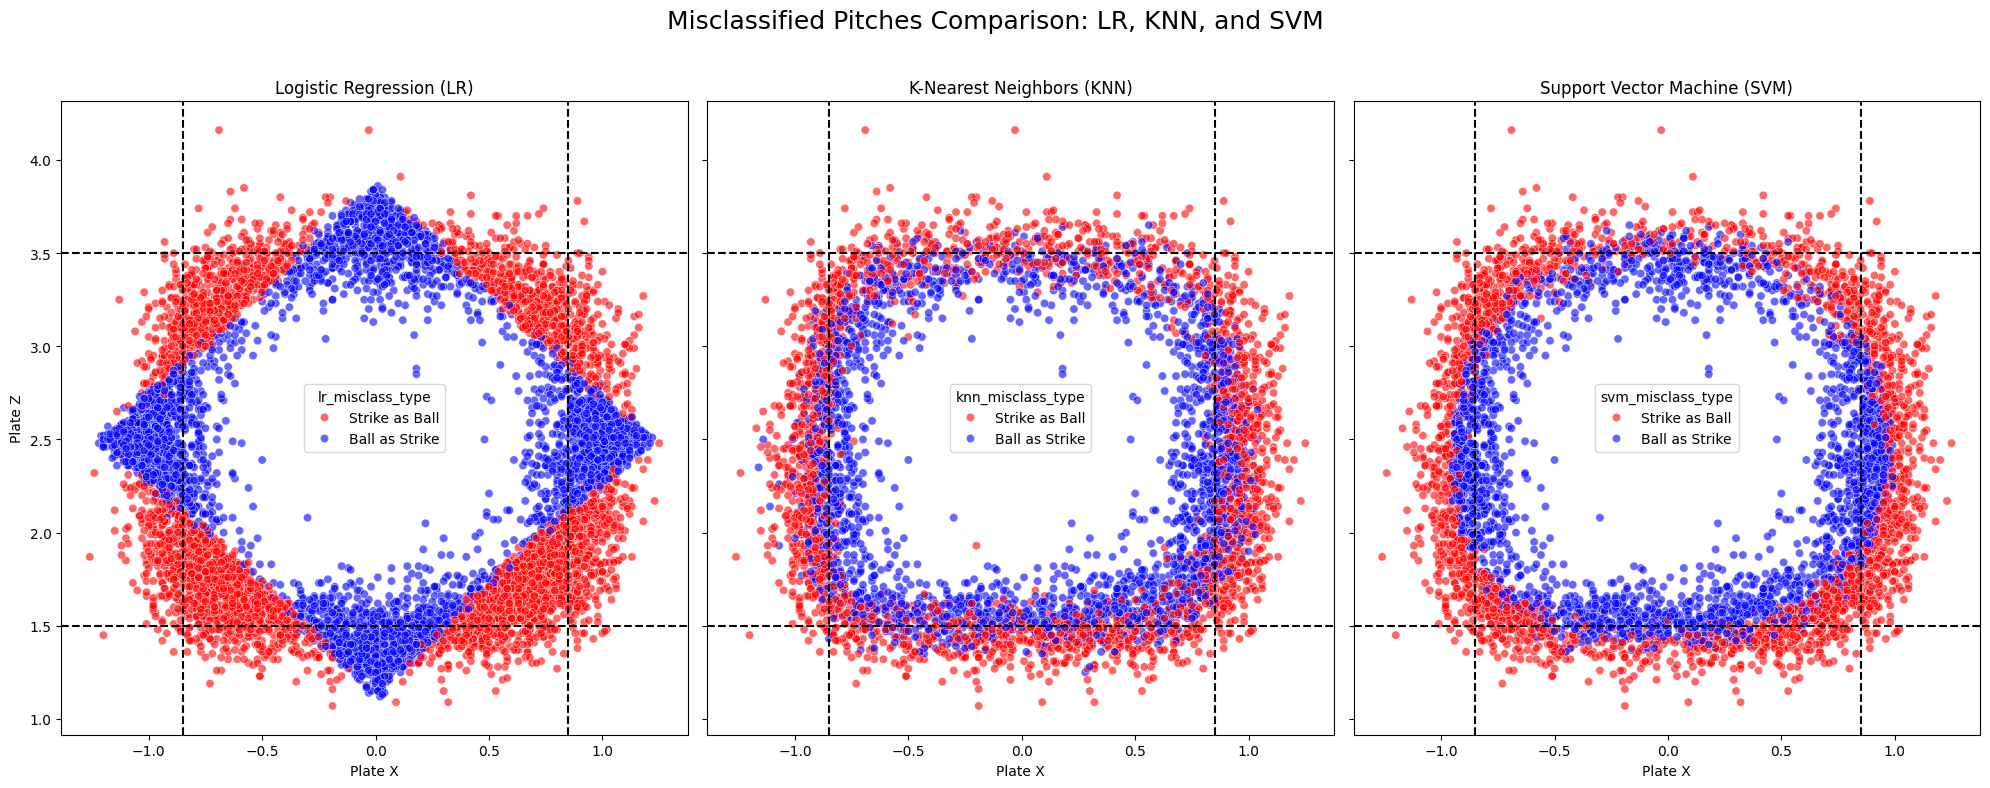

In [33]:
# Visualize the misclassified pitches
fig, axes = plt.subplots(1, 3, figsize=(20, 8), sharex=True, sharey=True)
fig.suptitle('Misclassified Pitches Comparison: LR, KNN, and SVM', fontsize=18)

# Plot LR misclassifications
sns.scatterplot(
    x='plate_x', y='plate_z', hue='lr_misclass_type', data=lr_misclassified,
    palette={'Strike as Ball': 'red', 'Ball as Strike': 'blue'},
    alpha=0.6, ax=axes[0]
)
axes[0].axvline(x=0.85, color='black', linestyle='--')
axes[0].axvline(x=-0.85, color='black', linestyle='--')
axes[0].axhline(y=1.5, color='black', linestyle='--')
axes[0].axhline(y=3.5, color='black', linestyle='--')
axes[0].set_title('Logistic Regression (LR)')
axes[0].set_xlabel('Plate X')
axes[0].set_ylabel('Plate Z')

# Plot KNN misclassifications
sns.scatterplot(
    x='plate_x', y='plate_z', hue='knn_misclass_type', data=knn_misclassified,
    palette={'Strike as Ball': 'red', 'Ball as Strike': 'blue'},
    alpha=0.6, ax=axes[1]
)
axes[1].axvline(x=0.85, color='black', linestyle='--')
axes[1].axvline(x=-0.85, color='black', linestyle='--')
axes[1].axhline(y=1.5, color='black', linestyle='--')
axes[1].axhline(y=3.5, color='black', linestyle='--')
axes[1].set_title('K-Nearest Neighbors (KNN)')
axes[1].set_xlabel('Plate X')

# Plot SVM misclassifications
sns.scatterplot(
    x='plate_x', y='plate_z', hue='svm_misclass_type', data=svm_misclassified,
    palette={'Strike as Ball': 'red', 'Ball as Strike': 'blue'},
    alpha=0.6, ax=axes[2]
)
axes[2].axvline(x=0.85, color='black', linestyle='--')
axes[2].axvline(x=-0.85, color='black', linestyle='--')
axes[2].axhline(y=1.5, color='black', linestyle='--')
axes[2].axhline(y=3.5, color='black', linestyle='--')
axes[2].set_title('Support Vector Machine (SVM)')
axes[2].set_xlabel('Plate X')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to accommodate suptitle
plt.show()

### Visualizations summarized
These graphs are by far my favorite part of this project.  

They show pitches (in blue) that we classified as strikes, but were called balls by the human umpire and pitches in red that we classified as balls that were called strikes by the human umpire.  

From the standpoint of a fan of the game and someone that's been around the sport for many years, it's interesting and entertaining to see the outliers. For instance, there are some pitches in there that were pretty much middle/middle of the strike zone that were called balls in real life. In my humble opinion, that adds character to the game but can be extrememly frustruating from the players perspective when you don't get the call you want (or in this case, clearly deserve).  

Now, to dig into the models a little deeper. The LR model is clearly the wrong choice, but the results are fascinating in my opinion. It's clearly showing a model that was fit in a linear fashion that didn't completely model the strikezone. We expected this when we started with the LR model, but the visualization here is great.  

The KNN and SVM models did a much better job of modeling the actual strike zone. The KNN model appears to have a slightly better shape (more rectangular vs. more oval) and there is less of a clear cutoff line for balls and strikes. Given the nature of the models, this is exactly what I would expect, but it's exciting to see expected results visually to know the model is working as expected.  

Moving forward, I would choose the KNN model for future work. This is due to the slightly better shape of the strike zone and the lack of a clear cutoff line, which I expect would be important for the future work outlined below.

# Discussion and Conclusion: 

### What I learned in the project  

This was a great learning experience for me. It's the largest modeling project I've built to-date, so I learned a lot about importing and handling the data. I also found the pybaseball package, which I'm sure I'll get a lot of use from in the future. I think the biggest takeaway for me was what I learned in the EDA portion. On first thought, I was going to go right into building the models, but on further analysis, I realized there was a lot of noise in the dataset, which caused me to rethink how I might clean the data further.  

### What could have gone better? Why or why not?

When I started this project, I knew I wouldn't be able to build perfect models for calling balls and strikes based on real data because of the imperfect (human) input to the data. As I look at the results of the misclassified pitches, especially the KNN and SVM models, I think the models are doing about as good a job as they'll be able to do (or at least close) with the given input. Does that mean I'm disappointed in the results? Quite the opposite, acutally. I think the models we have might be able to provide valuable insight into the human nature of umpiring.   

### Future works and ways to build off this project
I mentioned it earlier in the introduction, but I think the greatest value of this project will come in the future works. I think the models that we have can be analyzed for trends such as how is the strike zone affected by things like the current count (does it change in a 3-0 count vs an 0-2 count?), current score (does the strike zone expand when one of the teams has a big lead?) inning (does the strike zone expand or shrink or shift in the later innings?).  
  
Why is this valuable? If hitters (or pitchers) know that the strike zone gets bigger on an 0-2 pitch, they might be prepared to swing at a greater range of pitches than an 0-0 or 2-0 count.  

### Parting Words
I hope you enjoyed reading this project as much as I enjoyed creating it. I'm facscinated by the application of data science to the sport that I love and will continue to use baseball as the foundation of future projects. Thanks for reading!!